### IMPORTS ET CONFIGURATION

In [2]:
import sys
sys.path.append("/home/onyxia/work")

import os
import glob
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from osgeo import gdal, ogr
from libsigma import read_and_write as rw

from my_function import (
    create_stack, 
    rasterize_vector,
    extract_stats_by_class,
    calculate_ari,
    save_raster,
    save_multiband_raster,
    prepare_training_data
)



### Définition des chemins

In [3]:
BASE = "/home/onyxia/work"
DATA = BASE + "/data/projet_eval"
RESULTS = BASE + "/results"
FIG = RESULTS + "/figure"

os.makedirs(RESULTS, exist_ok=True)
os.makedirs(FIG, exist_ok=True)

vector_samples = DATA + "/PI_strates_bretagne_32630.shp"
ref_image = DATA + "/bretagne_24-25_B03.tif"

# PARTIE 1 - ANALYSE DES ÉCHANTILLONS

### Lecture des polygones d'échantillons

In [4]:
gdf = gpd.read_file(vector_samples)
print(gdf.head())


   id  strate      comment                                           geometry
0   1       3  lande basse  POLYGON ((441224.58 5366298.317, 441224.779 53...
1   2       3  lande basse  POLYGON ((441649.972 5366251.139, 441650.172 5...
2   3       3  lande basse  POLYGON ((441383.597 5366193.034, 441384.395 5...
3   4       2         None  POLYGON ((441336.658 5366402.088, 441337.257 5...
4   5       2         None  POLYGON ((441062.121 5366343.165, 441062.919 5...


### Comptage des polygones par classe

In [5]:
counts_poly = gdf["strate"].value_counts().sort_index()
print("\nNombre de polygones par classe :")
print(counts_poly)


Nombre de polygones par classe :
strate
2     86
3    121
4     71
Name: count, dtype: int64


### Création du diagramme en bâtons - Polygones

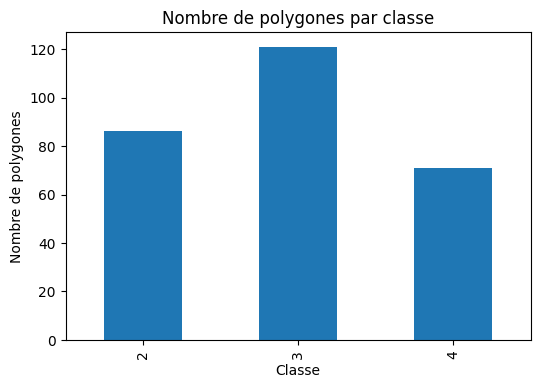

In [6]:
plt.figure(figsize=(6,4))
counts_poly.plot(kind="bar")
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.savefig(FIG + "/diag_baton_nb_poly_by_class.png", dpi=150)
plt.show()

###  Note sur la nomenclature

La classe 1 (Sol Nu) est absente des échantillons bretons.

Après vérification, seules trois classes sont présentes :
- Classe 2 : Herbe (86 polygones)
- Classe 3 : Landes (121 polygones)
- Classe 4 : Arbre (71 polygones)

Cette absence est cohérente avec le contexte géographique breton 
(climat océanique, forte couverture végétale permanente).

Conséquence : Le modèle ne peut discriminer que ces trois classes.

#  PARTIE 2 — RASTERISATION DES ÉCHANTILLONS

###  Rasterisation à 10m de résolution

In [7]:
out_raster = RESULTS + "/strates_rasterise.tif"

ds_ref = gdal.Open(ref_image)
gt = ds_ref.GetGeoTransform()
proj = ds_ref.GetProjection()
cols = ds_ref.RasterXSize
rows = ds_ref.RasterYSize

driver = gdal.GetDriverByName("GTiff")
ds_out = driver.Create(out_raster, cols, rows, 1, gdal.GDT_Byte)
ds_out.SetGeoTransform(gt)
ds_out.SetProjection(proj)

band = ds_out.GetRasterBand(1)
band.SetNoDataValue(0)
band.Fill(0)

ds_vect = ogr.Open(vector_samples)
layer = ds_vect.GetLayer()

gdal.RasterizeLayer(ds_out, [1], layer, options=["ATTRIBUTE=strate"])

ds_out = None
ds_ref = None
ds_vect = None

print("Raster des strates créé")

Raster des strates créé


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### Comptage des pixels par classe

In [9]:
arr = rw.load_img_as_array(out_raster).squeeze()
vals, counts = np.unique(arr[arr > 0], return_counts=True)

print("\nNombre de pixels par classe :")
for v, c in zip(vals, counts):
    print(f"Classe {v} : {c} pixels")



Nombre de pixels par classe :
Classe 2 : 1022 pixels
Classe 3 : 1599 pixels
Classe 4 : 1218 pixels


### Création du diagramme en bâtons - Pixels

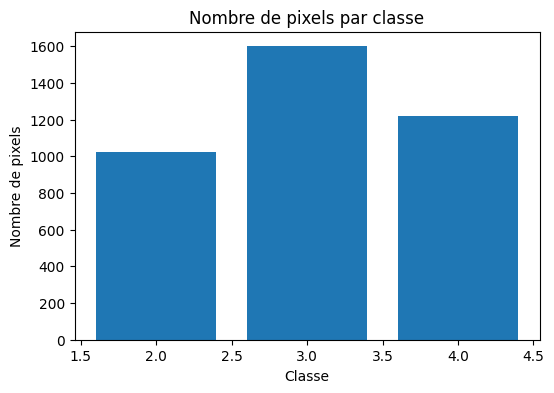

In [10]:
plt.figure(figsize=(6,4))
plt.bar(vals, counts)
plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")
plt.savefig(FIG + "/diag_baton_nb_pix_by_class.png", dpi=150)
plt.show()


# PARTIE 3A - CALCUL DE L'INDICE ARI

### SÉLECTION DES BANDES B03 ET B05

In [11]:
all_bands = sorted(glob.glob(DATA + "/bretagne_24-25_B*.tif"))
bands_B03 = sorted([b for b in all_bands if "B03" in b])
bands_B05 = sorted([b for b in all_bands if "B05" in b])

print(f"Dates trouvées - B03 : {len(bands_B03)}, B05 : {len(bands_B05)}")


Dates trouvées - B03 : 1, B05 : 1


###  Création des stacks multi-temporels

In [12]:
stack_B03 = RESULTS + "/stack_B03.tif"
stack_B05 = RESULTS + "/stack_B05.tif"

vrt_B03 = RESULTS + "/temp_B03.vrt"
vrt_B05 = RESULTS + "/temp_B05.vrt"

gdal.BuildVRT(vrt_B03, bands_B03, separate=True)
gdal.BuildVRT(vrt_B05, bands_B05, separate=True)

gdal.Translate(stack_B03, vrt_B03, format="GTiff")
gdal.Translate(stack_B05, vrt_B05, format="GTiff")

os.remove(vrt_B03)
os.remove(vrt_B05)

### Chargement et calcul de l'ARI

In [13]:
B03 = rw.load_img_as_array(stack_B03).astype("float32")
B05 = rw.load_img_as_array(stack_B05).astype("float32")

np.seterr(divide="ignore", invalid="ignore")
ARI = (1.0/B03 - 1.0/B05) / (1.0/B03 + 1.0/B05)
ARI[np.isnan(ARI)] = -9999


### Sauvegarde de la série temporelle ARI

In [14]:
out_ARI = RESULTS + "/ARI_serie_temp.tif"
ds_ref = gdal.Open(stack_B03)
driver = gdal.GetDriverByName("GTiff")

rows, cols, nb_dates = ARI.shape

ds_out = driver.Create(out_ARI, cols, rows, nb_dates, gdal.GDT_Float32)
ds_out.SetGeoTransform(ds_ref.GetGeoTransform())
ds_out.SetProjection(ds_ref.GetProjection())

for i in range(nb_dates):
    band = ds_out.GetRasterBand(i+1)
    band.WriteArray(ARI[:,:,i])
    band.SetNoDataValue(-9999)

ds_out = None
ds_ref = None

print("Série temporelle ARI sauvegardée")

Série temporelle ARI sauvegardée


# PARTIE 3B - ANALYSE PHÉNOLOGIQUE

### Extraction des statistiques par classe

In [15]:
# Extraction des statistiques par classe
ARI_loaded = rw.load_img_as_array(out_ARI)
strates = rw.load_img_as_array(out_raster).squeeze()

classes = [2, 3, 4]  
nb_dates = ARI_loaded.shape[2]

moyennes = np.zeros((3, nb_dates)) 
ecarts_types = np.zeros((3, nb_dates))

for i, classe in enumerate(classes):
    mask = (strates == classe)
    for date in range(nb_dates):
        valeurs = ARI_loaded[:, :, date][mask]
        valeurs = valeurs[valeurs != -9999]
        
        if len(valeurs) > 0:
            moyennes[i, date] = np.mean(valeurs)
            ecarts_types[i, date] = np.std(valeurs)
        else:
            moyennes[i, date] = np.nan
            ecarts_types[i, date] = np.nan

print("Statistiques calculées pour les 3 classes présentes")

Statistiques calculées pour les 3 classes présentes


### Création du graphique de phénologie

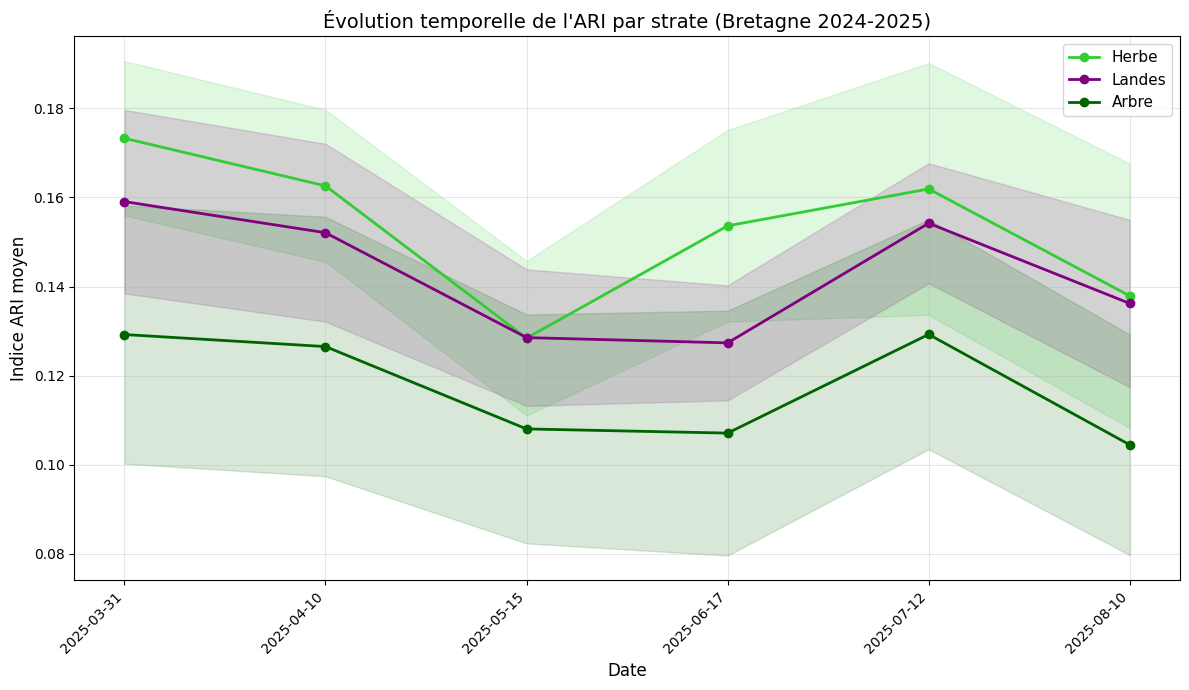

In [16]:
dates = ["2025-03-31", "2025-04-10", "2025-05-15", 
         "2025-06-17", "2025-07-12", "2025-08-10"]

plt.figure(figsize=(12, 7))

labels = ["Herbe", "Landes", "Arbre"]  
colors = ["limegreen", "purple", "darkgreen"]

for i in range(3): 
    plt.plot(dates, moyennes[i, :], label=labels[i], color=colors[i], 
             marker='o', linewidth=2, markersize=6)
    plt.fill_between(dates, moyennes[i, :] - ecarts_types[i, :],
                     moyennes[i, :] + ecarts_types[i, :],
                     alpha=0.15, color=colors[i])

plt.xlabel("Date", fontsize=12)
plt.ylabel("Indice ARI moyen", fontsize=12)
plt.title("Évolution temporelle de l'ARI par strate (Bretagne 2024-2025)", fontsize=14)
plt.legend(loc='best', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG + "/ARI_series.png", dpi=150, bbox_inches='tight')
plt.show()

### Analyse de la phénologie ARI

Observations générales :
Les valeurs ARI varient entre 0.10 et 0.18 pour toutes les classes. 
Les écarts-types importants indiquent une forte variabilité intra-classe.

Séparabilité des strates :
- Herbe : Valeurs les plus élevées (0.17-0.16), pic en juillet
- Landes : Profil similaire à l'Herbe (0.13-0.16)
- Arbre : Valeurs les plus faibles et stables (0.10-0.13)

Discrimination des Landes :
Les Landes ne se distinguent pas clairement avec l'ARI seul. 
Le profil temporel est proche de celui de l'Herbe, suggérant 
des confusions potentielles.

Variabilité temporelle :
Un creux apparaît en mai-juin, et un pic en juillet pour Herbe et Landes,
correspondant aux cycles de végétation printanière/estivale.

Conclusion :
L'ARI seul ne suffit pas à discriminer les Landes. La classification 
devra utiliser l'ensemble des bandes spectrales et la série temporelle.

# PARTIE 4 - CLASSIFICATION SUPERVISÉE

### IMPORT DES LIBRAIRIES SCIKIT-LEARN

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

### Liste des bandes Sentinel-2 utilisées

In [63]:
bandes_list = ["B02", "B03", "B04", "B05", "B06", "B07", 
               "B08", "B8A", "B11", "B12"]

### Création des stacks multi-temporels pour toutes les bandes

In [64]:
stacks_dict = {}

for bande in bandes_list:
    pattern = DATA + f"/bretagne_24-25_{bande}.tif"
    files = sorted(glob.glob(pattern))
    
    if len(files) == 0:
        continue
    
    vrt_temp = RESULTS + f"/temp_{bande}.vrt"
    stack_out = RESULTS + f"/stack_{bande}.tif"
    
    gdal.BuildVRT(vrt_temp, files, separate=True)
    gdal.Translate(stack_out, vrt_temp, format="GTiff")
    os.remove(vrt_temp)
    
    arr = rw.load_img_as_array(stack_out).astype("float32")
    stacks_dict[bande] = arr

print(f"{len(stacks_dict)} stacks créés")

10 stacks créés


### Assemblage des features (bandes spectrales + ARI)

In [68]:
all_features_list = []

for bande in bandes_list:
    if bande in stacks_dict:
        arr = stacks_dict[bande]
        nb_dates = arr.shape[2]
        for date_idx in range(nb_dates):
            all_features_list.append(arr[:, :, date_idx])

ARI_stack = rw.load_img_as_array(RESULTS + "/ARI_serie_temp.tif").astype("float32")
for date_idx in range(ARI_stack.shape[2]):
    all_features_list.append(ARI_stack[:, :, date_idx])

X_image = np.stack(all_features_list, axis=2)
print(f"Features assemblées : {X_image.shape[2]} variables")


Features assemblées : 66 variables


### Extraction des échantillons d'entraînement

In [67]:
strates_raster = rw.load_img_as_array(RESULTS + "/strates_rasterise.tif").squeeze()
mask = strates_raster > 0

rows, cols, nb_features = X_image.shape
X_flat = X_image.reshape(rows * cols, nb_features)
y_flat = strates_raster.flatten()

X = X_flat[mask.flatten(), :]
y = y_flat[mask.flatten()]

print(f"\nDonnées préparées : X {X.shape}, y {y.shape}")
print(f"Classes : {np.unique(y)}")
print(f"Distribution : {np.bincount(y.astype(int))[1:]}")


Données préparées : X (3839, 66), y (3839,)
Classes : [2 3 4]
Distribution : [   0 1022 1599 1218]


### OPTIMISATION DES HYPERPARAMÈTRES

### Définition de la grille de recherche

In [69]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 5]
}

nb_combinaisons = (len(param_grid['n_estimators']) * 
                   len(param_grid['max_depth']) * 
                   len(param_grid['max_features']) * 
                   len(param_grid['min_samples_leaf']))

print(f"\nRecherche sur grille : {nb_combinaisons} combinaisons")
print("Validation croisée : K=5")
print("Métrique : F1-score pondéré\n")


Recherche sur grille : 120 combinaisons
Validation croisée : K=5
Métrique : F1-score pondéré



### Lancement de GridSearchCV

In [70]:
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=0)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X, y)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  15.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  17.3s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  17.4s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  17.4s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  18.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  27.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  30.1s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  31.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  33.2s
[CV] END max_depth=None, max_feat

### Résultats de l'optimisation

In [71]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\nMeilleurs hyperparamètres :")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nScore F1 (validation croisée) : {best_score:.4f}")


Meilleurs hyperparamètres :
  max_depth: 15
  max_features: sqrt
  min_samples_leaf: 5
  n_estimators: 200

Score F1 (validation croisée) : 0.9042


### Affichage du top 10 des configurations

In [72]:
results_cv = pd.DataFrame(grid_search.cv_results_)
cols_important = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
results_top = results_cv[cols_important].sort_values('rank_test_score').head(10)

print("\nTop 10 des configurations :")
print(results_top.to_string(index=False))


Top 10 des configurations :
                                                                                 params  mean_test_score  std_test_score  rank_test_score
  {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}         0.904158        0.028371                1
  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 150}         0.904051        0.032042                2
  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}         0.903788        0.032866                3
  {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300}         0.903714        0.032985                4
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}         0.903659        0.028041                5
  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}         0.903659        0.028041                5
 {'ma

### ENTRAÎNEMENT DU MODÈLE FINAL


In [73]:
final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1, verbose=1)
final_model.fit(X, y)

print("Modèle final entraîné")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.4s


Modèle final entraîné


[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.9s finished


### Analyse de l'importance des variables

In [74]:
importances = final_model.feature_importances_

feature_names = []
for bande in bandes_list:
    if bande in stacks_dict:
        for i in range(6):
            feature_names.append(f"{bande}_date{i+1}")

for i in range(6):
    feature_names.append(f"ARI_date{i+1}")

importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 20 des variables les plus importantes :")
print(importance_df.head(20).to_string(index=False))


Top 20 des variables les plus importantes :
 Variable  Importance
B05_date4    0.055596
B08_date2    0.054643
B07_date2    0.053480
B06_date2    0.050451
B06_date1    0.048233
B08_date1    0.047060
B03_date4    0.045482
B8A_date2    0.044059
B07_date1    0.041131
B12_date3    0.040814
B03_date5    0.036992
B04_date3    0.035380
B05_date6    0.033471
B05_date5    0.033099
B11_date3    0.028357
B8A_date1    0.026060
B02_date5    0.020461
B03_date6    0.020383
B04_date5    0.019277
B12_date5    0.018431


### Graphique d'importance

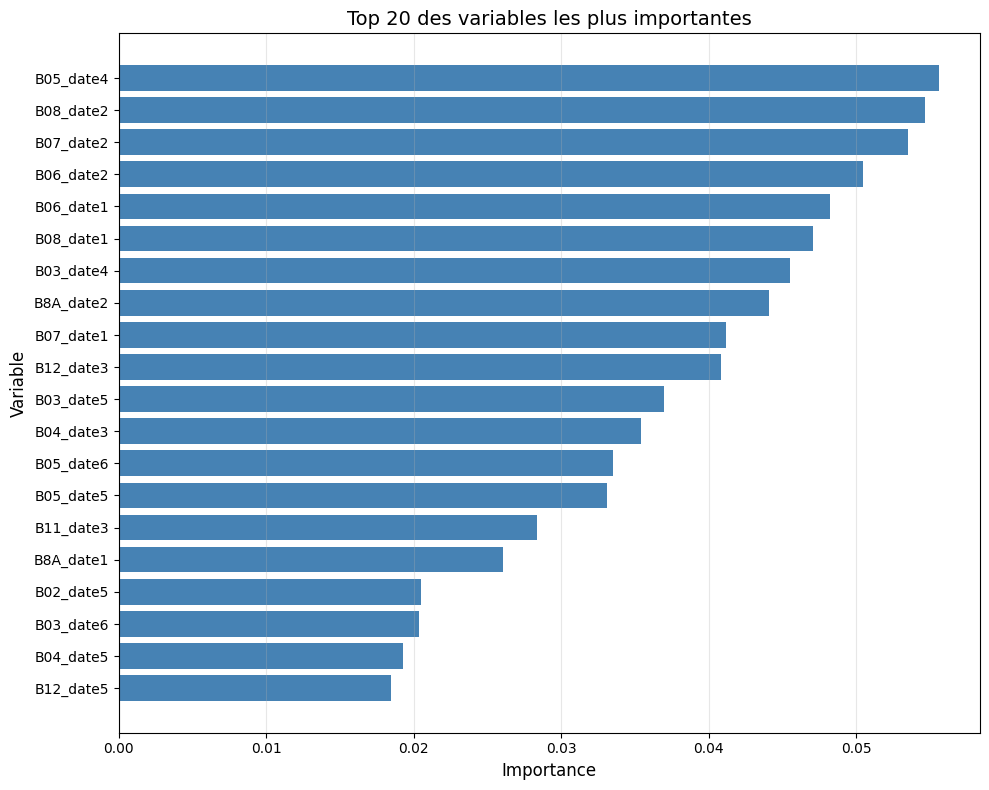

In [75]:
plt.figure(figsize=(10, 8))
top_n = 20
top_features = importance_df.head(top_n)

plt.barh(range(top_n), top_features['Importance'].values, color='steelblue')
plt.yticks(range(top_n), top_features['Variable'].values)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.title('Top 20 des variables les plus importantes', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(FIG + "/importance_variables.png", dpi=150, bbox_inches='tight')
plt.show()

### Production de la carte de classification

### PRÉDICTION SUR TOUTE L'IMAGE

In [76]:
predictions_flat = final_model.predict(X_flat)
predictions = predictions_flat.reshape(rows, cols).astype(np.uint8)

print(f"Prédiction terminée - Classes : {np.unique(predictions)}")

[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.3s


Prédiction terminée - Classes : [2 3 4]


[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    1.2s
[Parallel(n_jobs=9)]: Done 200 out of 200 | elapsed:    1.3s finished


### SAUVEGARDE DE LA CARTE

In [77]:
out_carte = RESULTS + "/carte_strates.tif"
ds_ref = gdal.Open(ref_image)
driver = gdal.GetDriverByName("GTiff")

ds_out = driver.Create(out_carte, cols, rows, 1, gdal.GDT_Byte)
ds_out.SetGeoTransform(ds_ref.GetGeoTransform())
ds_out.SetProjection(ds_ref.GetProjection())

band = ds_out.GetRasterBand(1)
band.WriteArray(predictions)
band.SetNoDataValue(0)

ds_out = None
ds_ref = None

print("Carte de classification sauvegardée")


Carte de classification sauvegardée


### ÉVALUATION DE LA QUALITÉ

### PRÉDICTION SUR LES ÉCHANTILLONS

In [78]:
y_pred = final_model.predict(X)
accuracy = accuracy_score(y, y_pred)

print(f"\nPrécision globale : {accuracy:.4f} ({accuracy*100:.2f}%)")


Précision globale : 0.9901 (99.01%)


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 200 out of 200 | elapsed:    0.1s finished


### MATRICE DE CONFUSION

In [79]:
labels = [1, 2, 3, 4]
cm = confusion_matrix(y, y_pred, labels=labels)

print("\nMatrice de confusion :")
print(cm)

class_labels = ["Sol Nu", "Herbe", "Landes", "Arbre"]

print(f"\nClasses dans y : {np.unique(y)}")
print(f"Classes prédites : {np.unique(y_pred)}")

print("\nRapport de classification :")
print(classification_report(y, y_pred, labels=labels, target_names=class_labels, 
                            digits=4, zero_division=0))



Matrice de confusion :
[[   0    0    0    0]
 [   0 1018    3    1]
 [   0    1 1585   13]
 [   0    4   16 1198]]

Classes dans y : [2 3 4]
Classes prédites : [2 3 4]

Rapport de classification :
              precision    recall  f1-score   support

      Sol Nu     0.0000    0.0000    0.0000         0
       Herbe     0.9951    0.9961    0.9956      1022
      Landes     0.9882    0.9912    0.9897      1599
       Arbre     0.9884    0.9836    0.9860      1218

    accuracy                         0.9901      3839
   macro avg     0.7429    0.7427    0.7428      3839
weighted avg     0.9901    0.9901    0.9901      3839



### VISUALISATION DE LA MATRICE DE CONFUSION

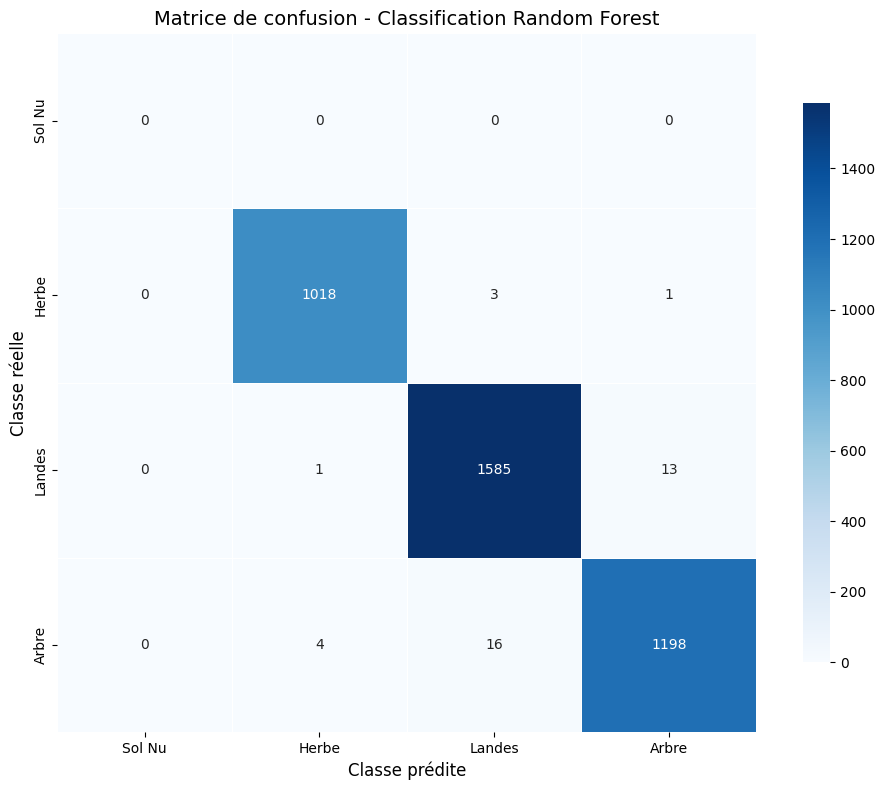

In [80]:
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.ylabel('Classe réelle', fontsize=12)
plt.xlabel('Classe prédite', fontsize=12)
plt.title('Matrice de confusion - Classification Random Forest', fontsize=14)
plt.tight_layout()
plt.savefig(FIG + "/matrice_confusion.png", dpi=150, bbox_inches='tight')
plt.show()

###  DISCUSSION

**Qualité du modèle :**
Le modèle atteint une précision de 99.01% sur les échantillons d'entraînement,
avec un F1-score en validation croisée de 90.42%. Ces résultats sont excellents.

Point d'attention : La précision sur les données d'entraînement (99%) est 
supérieure au score de validation croisée (90%), suggérant un léger surajustement,
bien que le score de validation reste très satisfaisant.

Confusions inter-classes :
Les confusions concernent principalement Landes-Arbre (29 pixels). Cette confusion
est cohérente : les landes arborescentes et jeunes arbres ont des signatures 
spectrales proches en PIR et Red-Edge. Les zones de transition (lisières) 
expliquent également ces confusions.

La classe Herbe est quasi parfaitement discriminée (99.6%), car elle présente 
une signature spectrale très distincte.

Rôle des variables :
Les bandes Red-Edge (B05-B07) et PIR (B08) sont cruciales, ainsi que les dates
printanières (avril) et estivales (juin). L'indice ARI contribue peu, confirmant
son faible pouvoir discriminant observé en Partie 3.

Limites méthodologiques :
- Absence de classe Sol Nu limitant l'applicabilité à d'autres contextes
- Série temporelle courte (6 dates) réduisant la capture phénologique
- Évaluation sur données d'entraînement sans jeu de test indépendant
- Déséquilibre modéré (Landes surreprésentée)

Améliorations possibles :
- Validation croisée spatiale pour mieux évaluer la généralisation
- Enrichissement avec NDVI, NDWI, texture
- Intégration de plus de dates pour capturer la phénologie complète
- Post-traitement par filtre majoritaire

Perspectives d'utilisation :
Ces cartes sont utilisables pour la gestion forestière et écologique en Bretagne :
cartographie des landes à Éricacées, suivi de la dynamique forestière, 
planification de la gestion des espaces naturels. La confiance est élevée pour 
l'Herbe (>99%), modérée pour la frontière Landes-Arbre (~98%). Une validation 
terrain est recommandée sur les zones de transition.